# Training a Classifier 

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

This is it. You have seen how to define neural networks, compute loss and make updates to the weights of the network.

Now you might be thinking,

## What about data?

Generally, when you have to deal with image, text, audio or video data, you can use standard python packages that load data into a numpy array. 
Then you can convert this array into a `torch.Tensor`.

* For images, packages such as **Pillow**, **OpenCV** are useful.
* For audio, packages such as **scipy** and **librosa**.
* For text, either **raw Python or Cython based loading**, or **NLTK** and **SpaCy** are useful.

Specifically for vision, we have created a package called `torchvision`, that has data loaders for common datasets such as *Imagenet*, *CIFAR10*, *MNIST*, etc. and data transformers for images, viz., `torchvision.datasets` and `torch.utils.data.DataLoader`.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the *CIFAR10* dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in *CIFAR-10* are of size 3x 32x32, i.e. 3-channel color images of 32x32 pixels in size.

![img](./content/60_min_blitz_4_train_img1.png)

(cifar10)

## Training an image classifier

We will do the following steps in order:

1. Load and normalizing the *CIFAR10* training and test datasets using `torchvision`
1. Define a Convolutional Neural Network
1. Define a loss function
1. Train the network on the training data
1. Test the network on the test data

## 1. Loading and normalizing CIFAR10 

#### Using `torchvision`, it’s extremely easy to load *CIFAR10*.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

#### The output of `torchvision` datasets are [PILImage](https://pillow.readthedocs.io/en/stable/reference/Image.html) images of range \[0, 1\]. We transform them to Tensors of normalized range \[-1, 1\]:

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # The parameters are the mean and std ((0., 0., 0.,), (1., 1., 1.)) OF THE EXISTING DATA, not what we want it to be!
    ]
)

Torchvision transforms documentation [here](https://pytorch.org/docs/stable/torchvision/transforms.html)
* `.Componse()` composes several transforms together - [ref](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Compose).
* `.ToTensor()` converts a PIL Image or numpy.ndarray to tensor - [ref](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.ToTensor).
* `.Normalize()` provide it a tuple of meand and std's per channel to normalise image - [ref](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize)

#### Fetch the train and test sets of CIFAR10:

In [4]:
trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)    # Note: train=True/False will fetch DIFFERENT PARTS OF THE DATASET.
# ^ See https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.CIFAR10
print(type(trainset))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)  
# ^ See https://pytorch.org/docs/stable/data.html
print(type(trainloader))

100.0%

Extracting ./data/cifar-10-python.tar.gz to ./data
<class 'torchvision.datasets.cifar.CIFAR10'>
<class 'torch.utils.data.dataloader.DataLoader'>


##### Note: definitely worth reading re. data utilities in PyTorch: [DataLoader docs](https://pytorch.org/docs/stable/data.html)
* Key use - **batching** ([docs](https://pytorch.org/docs/stable/data.html#loading-batched-and-non-batched-data))

In [5]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

Files already downloaded and verified


In [7]:
display(trainset)
print("-----")
display(trainloader)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

-----


In [21]:
# Dataset
# See: https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

# Can just get data item like so:
display(trainset[3])
print(trainset[3][0].size(), "\n", trainset[3][1])
# trainset[idx] returns a tuple: (image [torch.Tensor in our case], label)
# That is, one image, NOT a batch of 4.

print("----")
print(len(trainset))
print(len(testset))

(tensor([[[-0.7804, -0.7098, -0.7020,  ..., -0.4039, -0.3647, -0.3333],
          [-0.7412, -0.7333, -0.7490,  ..., -0.2549, -0.2471, -0.3333],
          [-0.6941, -0.6863, -0.5529,  ..., -0.2706, -0.1608, -0.2549],
          ...,
          [-0.3490, -0.3176, -0.3412,  ..., -0.2235, -0.2941, -0.3647],
          [-0.3098, -0.2941, -0.2706,  ..., -0.3725, -0.4039, -0.3569],
          [-0.2392, -0.2627, -0.2706,  ..., -0.5765, -0.5059, -0.4353]],
 
         [[-0.8039, -0.7333, -0.7255,  ..., -0.4745, -0.4353, -0.4039],
          [-0.7804, -0.7647, -0.7882,  ..., -0.3569, -0.3569, -0.4353],
          [-0.7490, -0.7412, -0.6078,  ..., -0.4039, -0.3020, -0.3961],
          ...,
          [-0.4275, -0.3961, -0.4196,  ..., -0.2706, -0.3412, -0.4118],
          [-0.4353, -0.4196, -0.3961,  ..., -0.4196, -0.4510, -0.4039],
          [-0.3882, -0.4118, -0.4118,  ..., -0.6314, -0.5608, -0.4902]],
 
         [[-0.9216, -0.8510, -0.8431,  ..., -0.6941, -0.6627, -0.6314],
          [-0.8980, -0.8902,

torch.Size([3, 32, 32]) 
 4
----
50000
10000


In [10]:
# We manually defining the classes?
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#### Let us show some of the training images, for fun:

In [11]:
import matplotlib.pyplot as plt
import numpy as np

In [12]:
# Function to show an image
def imshow(img, verbose=False):
    img = img / 2 + 0.5  # Unnormalize
    if verbose:
        print("type before .numpy() call: {}".format(type(img)))
    npimg = img.numpy()
    if verbose:
        print("type after .numpy() call: {}".format(type(img)))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [13]:
# Get some images - use an iterator (on the DataLoader!).
dataiter = iter(trainloader)

In [23]:
images, labels = dataiter.next()
print(type(images), type(labels))
print(images.size())  # We get a BATCH of 4 images, each 3 channels and 32x32.
print(labels)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([4, 3, 32, 32])
tensor([4, 1, 3, 5])


##### **Why is it called image_s_ and label_s_?**
Because automatic batching of size 4 has already been applied, so `images` has `torch.Size([4, 3, 32, 32])` (note the `4`).

In [26]:
# Show images.

grid = torchvision.utils.make_grid(images)
# ^ ref: https://pytorch.org/docs/stable/torchvision/utils.html#torchvision.utils.make_grid
# It makes a grid with padding (output here 3 channels x 32+padding height x 32*4+padding length).

print(type(grid), "\n---\n", grid, "\n---\n", grid.size())

<class 'torch.Tensor'> 
---
 tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000, -0.6314,  ..., -0.4196,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.2392,  ...,  0.1922,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000, -0.5843,  ..., -0.5608,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.3882,  ...,  0.1216,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.000

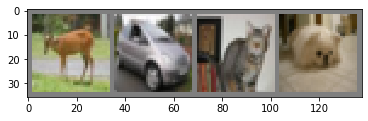

In [27]:
imshow(grid)

In [28]:
# Print labels:
print(' '.join('{:5s}'.format(classes[labels[j]]) for j in range(4)))

deer  car   cat   dog  


## 2. Define a Convolutional Neural Network

#### Copy the neural network from the Neural Networks section before and modify it to take 3-channel images (instead of 1-channel images as it was defined). 

In [29]:
import torch.nn as nn
import torch.nn.functional as F

In [30]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # BTW, don't seem to explicitly define batch size here or in __init__() - the input `x` IS EPECTED TO BE BATCH-ISED already, should handle any batch size.
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [31]:
net = Net()

## 3. Define a Loss function and optimizer

##### Let’s use a **Classification Cross-Entropy** loss and **SGD with momentum**. 

In [32]:
import torch.optim as optim

In [34]:
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. Train the network

##### This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize. 

In [38]:
for epoch in range(3):  # loop over the dataset multiple times.
    
    running_loss = 0.0
    
    for idx, data in enumerate(trainloader, 0):  # Iterate through training dat: will be in BATCHES (of 4), technically, "mini-batches"!
        
        # Get the inputs; data is a list of [inputs, labels].
        inputs, labels = data  # Open up the tuple.
        
        # Zero the parameter gradients.
        optimiser.zero_grad()  # Apparently can call `.zero_grad()` **through** the optimiser.
        
        # Main step: forward + backward + optimise (update weights).
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step()
        
        # Print statistics.
        running_loss += loss.item()  # `.item()` just gets scalar value.
        if idx % 2000 == 1999:  # Print every 2000 mini-batches.
            print("[{epoch:d}, {batches:5d}] loss: {loss:.3f}".format(epoch=epoch+1, batches=idx+1, loss=running_loss/2000))  # `runnig_loss` is for keeping track of the batch's (mean) loss.
            running_loss = 0.0

print("Finished training.")

[1,  2000] loss: 2.224
[1,  4000] loss: 1.899
[1,  6000] loss: 1.705
[1,  8000] loss: 1.602
[1, 10000] loss: 1.537
[1, 12000] loss: 1.473
[2,  2000] loss: 1.427
[2,  4000] loss: 1.383
[2,  6000] loss: 1.355
[2,  8000] loss: 1.355
[2, 10000] loss: 1.351
[2, 12000] loss: 1.309
[3,  2000] loss: 1.265
[3,  4000] loss: 1.225
[3,  6000] loss: 1.237
[3,  8000] loss: 1.233
[3, 10000] loss: 1.203
[3, 12000] loss: 1.204
Finished training.


## 5. Test the network on the test data

We have trained the network for 3 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. 
If the prediction is correct, we add the sample to the list of correct predictions.

#### Okay, first step. Let us display an image from the test set to get familiar. 

In [39]:
dataiter = iter(testloader)  # Grab data from the **test** sample now.
images, labels = dataiter.next()

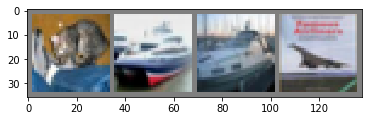

cat   ship  ship  plane


In [41]:
# Print images.
grid = torchvision.utils.make_grid(images)
imshow(grid)
print(' '.join('{:5s}'.format(classes[labels[j]]) for j in range(4)))

#### Okay, now let us see what the neural network thinks these examples above are:

In [42]:
outputs = net(images)
display(outputs)

tensor([[-1.2878, -0.9623, -0.1424,  4.1226, -0.9855,  3.3889, -2.1245,  1.3772,
          2.3053, -1.7221],
        [ 5.3849,  7.9187, -2.3839, -2.5407, -5.1791, -5.6475, -5.7884, -2.8265,
          6.0672,  5.0593],
        [ 2.2604,  4.0723, -0.9689, -1.2213, -2.3490, -2.9686, -2.6740, -2.0063,
          3.8347,  2.4865],
        [ 3.3260,  2.7925, -0.2791, -1.2800, -2.1023, -3.5005, -2.9844, -1.6432,
          4.0963,  2.7930]], grad_fn=<AddmmBackward>)

The outputs are energies for the 10 classes. 

The higher the energy for a class, the more the network thinks that the image is of the particular class. 

So, let’s get the index of the highest energy: 

In [44]:
_, predicted = torch.max(outputs, 1)
display(predicted)

tensor([3, 1, 1, 8])

In [54]:
print("Predicted: ", " ".join("{:5s}".format(classes[predicted[j]]) for j in range(4)))

Predicted:  frog  deer  horse bird 


The results seem pretty good (nope).

Let us look at how the network performs on the whole dataset.

In [55]:
correct = 0
total = 0

In [56]:
with torch.no_grad():  # Halt gradient tracking.
    for data in testloader: # Iterate over test batches.
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [58]:
print("Accuracy of the network on the 10000 test images: {:.3f}%".format(100 * correct / total))

Accuracy of the network on the 10000 test images: 57.580%


That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

#### Hmmm, what are the classes that performed well, and the classes that did not perform well: 

In [59]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# Just keep tallies for class_correct and class_total for each class.
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

In [60]:
for i in range(10):
    print("Accuracy of {:5s} : {:.2f}%".format(classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 58.00%
Accuracy of car   : 70.30%
Accuracy of bird  : 39.20%
Accuracy of cat   : 31.90%
Accuracy of deer  : 51.80%
Accuracy of dog   : 53.80%
Accuracy of frog  : 64.00%
Accuracy of horse : 65.70%
Accuracy of ship  : 73.60%
Accuracy of truck : 67.50%


Okay, so what next?

How do we run these neural networks on the GPU?

## Training on GPU

Just like how you transfer a Tensor onto the GPU, you **transfer the neural net onto the GPU**.

#### Let’s first define our device as the first visible cuda device if we have CUDA available: 

In [61]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [62]:
# Assuming that we are on a CUDA machine, this should print a CUDA device:
display(device)

device(type='cuda', index=0)

The rest of this section assumes that `device` is a CUDA device.

Then these methods will recursively go over all modules and convert their parameters and buffers to CUDA tensors:

In [63]:
# Transfer the net to CUDA!
# net.to(device)  # `.to(<device>)`

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

##### Remember that you will have to **send the inputs and targets at every step to the GPU** too: 

In [66]:
# Like so: inputs, labels = data[0].to(device), data[1].to(device)

#### Actually train on GPU 

In [67]:
net = net.to(device)

In [69]:
optimiser = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [70]:
for epoch in range(3):  # loop over the dataset multiple times.
    
    running_loss = 0.0
    
    for idx, data in enumerate(trainloader, 0):  # Iterate through training dat: will be in BATCHES (of 4), technically, "mini-batches"!
        
        # Get the inputs; data is a list of [inputs, labels].
        inputs, labels = data[0].to(device), data[1].to(device)  # Open up the tuple.
        
        # Zero the parameter gradients.
        optimiser.zero_grad()  # Apparently can call `.zero_grad()` **through** the optimiser.
        
        # Main step: forward + backward + optimise (update weights).
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step()
        
        # Print statistics.
        running_loss += loss.item()  # `.item()` just gets scalar value.
        if idx % 2000 == 1999:  # Print every 2000 mini-batches.
            print("[{epoch:d}, {batches:5d}] loss: {loss:.3f}".format(epoch=epoch+1, batches=idx+1, loss=running_loss/2000))  # `runnig_loss` is for keeping track of the batch's (mean) loss.
            running_loss = 0.0

print("Finished training.")

[1,  2000] loss: 1.116
[1,  4000] loss: 1.144
[1,  6000] loss: 1.140
[1,  8000] loss: 1.147
[1, 10000] loss: 1.141
[1, 12000] loss: 1.141
[2,  2000] loss: 1.050
[2,  4000] loss: 1.061
[2,  6000] loss: 1.099
[2,  8000] loss: 1.045
[2, 10000] loss: 1.088
[2, 12000] loss: 1.063
[3,  2000] loss: 1.001
[3,  4000] loss: 1.012
[3,  6000] loss: 1.017
[3,  8000] loss: 1.039
[3, 10000] loss: 1.010
[3, 12000] loss: 1.039
Finished training.


Why dont I notice MASSIVE speedup compared to CPU? Because your network is really small.

##### **Exercise:**
Try increasing the width of your network (argument 2 of the first nn.Conv2d, and argument 1 of the second nn.Conv2d – they need to be the same number), see what kind of speedup you get.

In [71]:
# I'm willing to believe that the speedup will be significant in this case.

#### **Goals achieved:**
* Understanding PyTorch’s Tensor library and neural networks at a high level.
* Train a small neural network to classify images

#### **Further reading**
* [Train neural nets to play video games](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)
* [Train a state-of-the-art ResNet network on imagenet](https://github.com/pytorch/examples/tree/master/imagenet)
* [Train a face generator using Generative Adversarial Networks](https://github.com/pytorch/examples/tree/master/dcgan)
* [Train a word-level language model using Recurrent LSTM networks](https://github.com/pytorch/examples/tree/master/word_language_model)
* [More examples](https://github.com/pytorch/examples)
* [More tutorials](https://github.com/pytorch/tutorials)